In [14]:
from skdim.id import TwoNN

from drn_interactions.load import load_spikes, load_waveforms, load_neurons, load_derived_generic, get_fig_dir
from drn_interactions.spikes import SpikesHandler


from sklearn.feature_extraction.text import TfidfTransformer
from umap import UMAP
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from binit.bin import which_bin

In [ ]:
# Migrate to other notebook

In [15]:
outdir = get_fig_dir() / "eeg"
outdir.mkdir(exist_ok=True)

In [2]:
def get_state_piv(spikes, eeg, state_col="state", index_name="bin", eeg_time_col="timepoint_s"):
    spikes = spikes.copy()
    return (
        spikes
        .reset_index()
        .assign(eeg_time = lambda x: which_bin(x[index_name].values, eeg[eeg_time_col].values, time_before=0, time_after=2))
        .merge(eeg, left_on="eeg_time", right_on=eeg_time_col)
        .set_index(index_name)
        [list(spikes.columns) + [state_col]]
    )

def get_state_long(spikes, eeg, index_name="bin", eeg_time_col="timepoint_s"):
    return (
        spikes
        .reset_index()
        .copy()
        .assign(eeg_bin = lambda x: which_bin(x[index_name].values, eeg[eeg_time_col].values, time_before=0, time_after=2))
        .merge(eeg, left_on="eeg_bin", right_on="timepoint_s")
        .drop("timepoint_s", axis=1)
    )

<AxesSubplot:xlabel='session_name'>

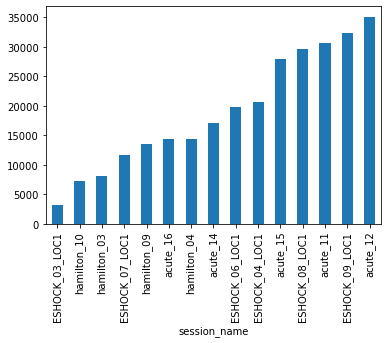

In [3]:
eeg = load_derived_generic("eeg_states.csv")
neurons = load_neurons()
neurons.merge(eeg).groupby("session_name").apply(len).sort_values().plot(kind="bar")

In [62]:
session = "acute_15"
sh = SpikesHandler(block="pre", bin_width=1, session_names=[session])
eeg_sub = eeg.loc[lambda x: x.session_name == session]
df = sh.binned_piv.loc[lambda x: x.index < 1800]
X = TfidfTransformer().fit_transform(df.values)
# X = df.values

y = get_state_long(df.reset_index(), eeg_sub, index_name="bin", eeg_time_col="timepoint_s")["cluster"].values
y = np.where(y == "sw", 1, 0)

mod = UMAP().fit(X, y)
df1 = pd.DataFrame(mod.embedding_, columns=["d1", "d2"], index=df.index).reset_index()
df1 = get_state_long(df1, eeg_sub, index_name="bin", eeg_time_col="timepoint_s")
px.scatter(df1, x="d1", y="d2", color="cluster")


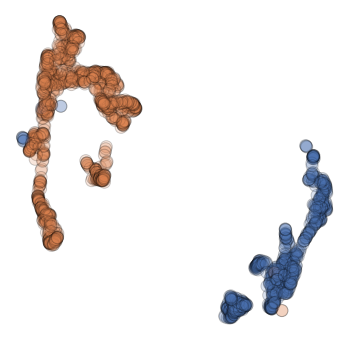

In [77]:
import seaborn as sns
sns.set_theme(context="poster", style="ticks")
_, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df1, x="d1", y="d2", hue="cluster", ax=ax, alpha=0.2, edgecolor="black")
ax.axis("off")
ax.legend().remove()

plt.savefig(outdir / "EEG UMAP.png", transparent=True, dpi=500)


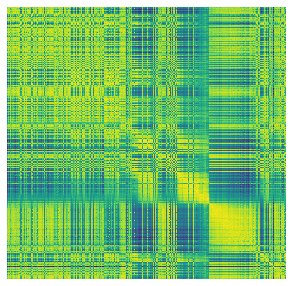

In [78]:
from sklearn.metrics.pairwise import pairwise_distances

_, ax  = plt.subplots(figsize=(5, 5))

X = 1 - pairwise_distances(df.values, metric="cosine")

X = X / np.max(X)

sns.heatmap(X, cmap="viridis", vmax=1, cbar=False, 
xticklabels=[], yticklabels=[], ax=ax)
plt.savefig(outdir / "similarity_map.png", dpi=300, transparent=True)

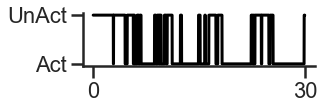

In [81]:
_, ax = plt.subplots(figsize=(5, 2))

ax.plot(np.arange(len(y)) / 60 ,y, color="black")

ax.set_yticks([0, 1])
ax.set_xticks([0, 30])
ax.set_yticklabels(["Act", "UnAct"])

sns.despine()
plt.tight_layout()
plt.savefig(outdir / "state.png", dpi=300, transparent=True)

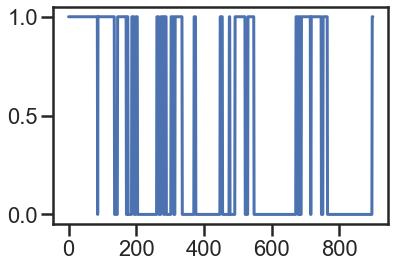

In [73]:
plt.plot(np.where(eeg_sub["cluster"] == "sw", 1, 0))

In [47]:
eeg_sub

,timepoint_s,cluster,quality,session_name
7847,0.0,act,good,acute_12
7848,2.0,act,good,acute_12
7849,4.0,act,good,acute_12
7850,6.0,act,good,acute_12
7851,8.0,act,good,acute_12
...,...,...,...,...
8742,1790.0,sw,good,acute_12
8743,1792.0,sw,good,acute_12
8744,1794.0,sw,good,acute_12
8745,1796.0,sw,good,acute_12


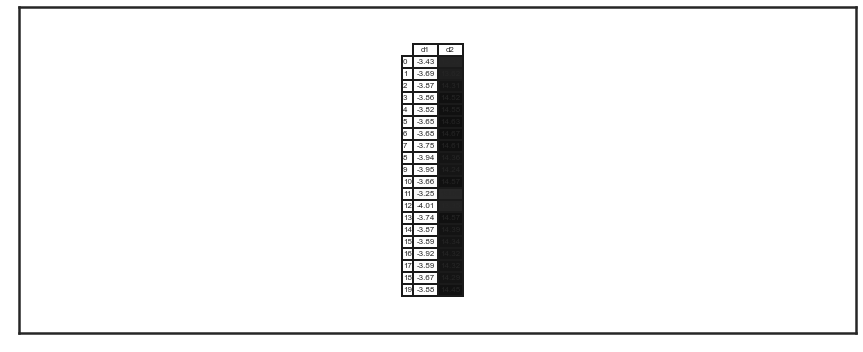

In [30]:
df2 = df1[["d1", "d2"]].iloc[:20]

df = df2
# df2.index.name = "neuron"
vals = np.round(df.values, 2)

norm = plt.Normalize(vals.min(), vals.max()+1)
colours = plt.cm.Greys(norm(vals))

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.03]*vals.shape[1], loc='center', 
                    cellColours=colours)

In [31]:
df2.rename(columns=dict(d1="Dimention1", d2="Dimention2")

,d1,d2
0,-3.428888,13.215427
1,-3.689285,13.618591
2,-3.868329,14.309026
3,-3.864330,14.521155
4,-3.815000,14.575557
5,-3.652249,14.625636
6,-3.680347,14.665692
7,-3.749276,14.609978
8,-3.935905,14.355324
9,-3.949018,14.239729


In [31]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline

In [34]:
session = "acute_11"

sh = SpikesHandler(block="pre", bin_width=1, session_names=[session])
eeg_sub = eeg.loc[lambda x: x.session_name == session]
df = sh.binned_piv.loc[lambda x: x.index < 1800]

state = get_state_long(df.reset_index(), eeg_sub, index_name="bin", eeg_time_col="timepoint_s")["cluster"].values
y = LabelEncoder().fit_transform(state)
X = df.values

pipe = make_pipeline(TfidfTransformer(), UMAP(), KNeighborsClassifier())

res = cross_val_score(pipe, X, y, scoring="f1_macro", cv=KFold(shuffle=True))


In [36]:
scores = {}
for session in neurons.merge(eeg).session_name.unique():
    sh = SpikesHandler(block="pre", bin_width=1, session_names=[session])
    eeg_sub = eeg.loc[lambda x: x.session_name == session]
    df = sh.binned_piv.loc[lambda x: x.index < 1800]

    state = get_state_long(df.reset_index(), eeg_sub, index_name="bin", eeg_time_col="timepoint_s")["cluster"].values
    y = LabelEncoder().fit_transform(state)
    X = df.values

    pipe = make_pipeline(TfidfTransformer(), UMAP(), KNeighborsClassifier())

    res = cross_val_score(pipe, X, y, scoring="f1_macro", cv=KFold(shuffle=True))
    scores[session] = res


In [38]:
pd.DataFrame(scores).mean()

ESHOCK_03_LOC1    0.789665
ESHOCK_04_LOC1    0.760977
ESHOCK_06_LOC1    0.651826
ESHOCK_07_LOC1    0.903230
ESHOCK_08_LOC1    0.981672
ESHOCK_09_LOC1    0.950225
hamilton_10       0.879361
hamilton_03       0.782496
hamilton_04       0.547242
hamilton_09       0.759327
acute_15          0.764976
acute_16          0.969167
acute_14          0.703703
acute_12          0.972549
acute_11          0.809012
dtype: float64

In [39]:
scores = {}
for session in neurons.merge(eeg).session_name.unique():
    sh = SpikesHandler(block="pre", bin_width=1, session_names=[session])
    eeg_sub = eeg.loc[lambda x: x.session_name == session]
    df = sh.binned_piv.loc[lambda x: x.index < 1800]

    state = get_state_long(df.reset_index(), eeg_sub, index_name="bin", eeg_time_col="timepoint_s")["cluster"].values
    state = np.random.permutation(state)
    y = LabelEncoder().fit_transform(state)
    X = df.values

    pipe = make_pipeline(TfidfTransformer(), UMAP(), KNeighborsClassifier())

    res = cross_val_score(pipe, X, y, scoring="f1_macro", cv=KFold(shuffle=True))
    scores[session] = res


In [40]:
pd.DataFrame(scores).mean()

ESHOCK_03_LOC1    0.480736
ESHOCK_04_LOC1    0.498427
ESHOCK_06_LOC1    0.457796
ESHOCK_07_LOC1    0.478612
ESHOCK_08_LOC1    0.503008
ESHOCK_09_LOC1    0.477179
hamilton_10       0.499292
hamilton_03       0.470187
hamilton_04       0.478191
hamilton_09       0.479779
acute_15          0.460042
acute_16          0.502319
acute_14          0.482095
acute_12          0.479156
acute_11          0.457420
dtype: float64

In [ ]:
scores = {}
for session in neurons.merge(eeg).session_name.unique():
    sh = SpikesHandler(block="pre", bin_width=1, session_names=[session])
    eeg_sub = eeg.loc[lambda x: x.session_name == session]
    df = sh.binned_piv.loc[lambda x: x.index < 1800]

    state = get_state_long(df.reset_index(), eeg_sub, index_name="bin", eeg_time_col="timepoint_s")["cluster"].values
    y = LabelEncoder().fit_transform(state)
    X = df.values

    pipe = make_pipeline(TfidfTransformer(), UMAP(), KNeighborsClassifier())

    res = cross_val_score(pipe, X, y, scoring="f1_macro", cv=KFold(shuffle=True))
    scores[session] = res


In [63]:
from skdim.id import FisherS, TwoNN, MLE, MADA, CorrInt, DANCo

sessions = neurons.merge(eeg).session_name.unique()
scores = []
for i, session in enumerate(sessions):
    sh = SpikesHandler(block="pre", bin_width=1, session_names=[session])
    eeg_sub = eeg.loc[lambda x: x.session_name == session]
    df = sh.binned_piv.loc[lambda x: x.index < 1800]

    state = get_state_long(df.reset_index(), eeg_sub, index_name="bin", eeg_time_col="timepoint_s")["cluster"].values

    X = TfidfTransformer().fit_transform(df.values)

    sw_state = FisherS().fit(X.toarray()[state == "sw"]).dimension_
    act_state = FisherS().fit(X.toarray()[state == "act"]).dimension_
    scores.append([session, sw_state, act_state])

Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x000002608E667950>
Traceback (most recent call last):
  File "c:\Users\roryl\.conda\envs\drn-interactions\lib\weakref.py", line 110, in remove
    self = selfref()
KeyboardInterrupt


WilcoxonResult(statistic=57.0, pvalue=0.890380859375)


(0.0, 15.0)

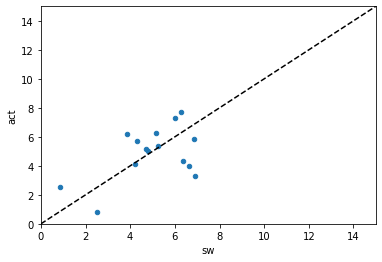

In [ ]:
from scipy.stats import wilcoxon

res = pd.DataFrame(scores, columns=["session", "sw", "act"])
print(wilcoxon(res["sw"], res["act"]))

ax = res.plot(x="sw", y="act", kind="scatter")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black", linestyle="dashed")
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)

In [17]:
y = get_state_long(df.reset_index(), eeg_sub, index_name="bin", eeg_time_col="timepoint_s")["cluster"].values

# df.reset_index()

In [169]:
from skdim.id import FisherS

In [170]:
mod = FisherS().fit(X.toarray())
mod.dimension_

3.3626486314382484

In [171]:
mod = FisherS().fit(X.toarray()[df1.cluster == "act"])
mod.dimension_

3.4595566724868765

In [172]:
mod = FisherS().fit(X.toarray()[df1.cluster == "sw"])
mod.dimension_

4.684738635526926

In [152]:
import numpy as np


X[df1.cluster == "act"]

<3267x39 sparse matrix of type '<class 'numpy.float64'>'
	with 50309 stored elements in Compressed Sparse Row format>